In [192]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [193]:
PATH = "./Data/FER2013"

trainDir = os.path.join(PATH, 'train')
testDir = os.path.join(PATH, 'test')

In [194]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224) # MobileNetV2 requires these dims

In [195]:
trainingDataSet = tf.keras.utils.image_dataset_from_directory(trainDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
testingDataSet = tf.keras.utils.image_dataset_from_directory(testDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


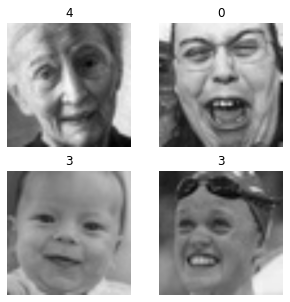

In [196]:
classNames = trainingDataSet.class_names

plt.figure(figsize=(5,5))
for images, labels in trainingDataSet.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i+ 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")


In [197]:
#Buffered prefetching to help performance
autotune = tf.data.AUTOTUNE

trainingDataSet = trainingDataSet.prefetch(buffer_size=autotune)
testingDataSet = testingDataSet.prefetch(buffer_size=autotune)

In [198]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [212]:
#Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [200]:
#Download pre-trained model
IMG_SHAPE = IMG_SIZE + (3,)
baseModel = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [201]:
#convert image to blocks of features
image_batch, label_batch = next(iter(trainingDataSet))
feature_batch = baseModel(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [202]:
baseModel.trainable = True

In [203]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(32, 1280)


In [204]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(32, 1)


In [211]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = baseModel(x, training = False)
x = global_avg_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

###FIX loss:Nan ISSUE CROSS REFERENCE WITH VIDEO CODE --------------------------------------------------------***************************************
# base_input = baseModel.layers[0].input  
# base_output = baseModel.layers[-2].output


# final_output = layers.Dense(128)(base_output) #add new layer after output of global pooling layer
# final_output = layers.Activation('relu')(final_output) #activation function
# final_output = layers.Dense(64)(final_output)
# final_output = layers.Activation('relu')(final_output)
# final_output = layers.Dense(7, activation='softmax')(final_output) #classification layer

model = keras.Model(inputs = inputs, outputs = outputs)



KerasTensor(type_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


In [206]:
base_learn_rate = 0.000001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=base_learn_rate)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [207]:
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_13 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                          

In [208]:
len(model.trainable_variables)

158

In [209]:
model.fit(trainingDataSet, epochs=10)

Epoch 1/10


KeyboardInterrupt: 